# Note

The following code was taken from Github https://github.com/kpchamp/SindyAutoencoders.
We adapted it slightly for our AMATH 575 final project, but credit goes to the original authors, Champion, et al.

In [1]:
import sys
sys.path.append("../../src")
import os
import numpy as np
import pickle
from example_lorenz import get_lorenz_data, generate_lorenz_data
from autoencoder import full_network
from training import create_feed_dictionary
from sindy_utils import sindy_simulate
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
data_path = os.getcwd() + '/'
save_name = 'model1'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name

autoencoder_network = full_network(params)
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Single trajectory plots

In [3]:
t = np.arange(0,5,.01)
z0 = np.array([[.01,.01,.01]])

test_data = generate_lorenz_data(z0, t, params['input_dim'], linear=False, normalization=np.array([1/40,1/40,1/40]), rho=1.0)
test_data['x'] = test_data['x'].reshape((-1,params['input_dim']))
test_data['dx'] = test_data['dx'].reshape((-1,params['input_dim']))
test_data['z'] = test_data['z'].reshape((-1,params['latent_dim']))
test_data['dz'] = test_data['dz'].reshape((-1,params['latent_dim']))

In [4]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from /home/evan/dev/school/amath575/SindyAutoencoders/examples/lorenz/model1


In [5]:
a1 = 1
a2 = test_data['sindy_coefficients'][2,0]/test_set_results['sindy_coefficients'][2,0]
a3 = np.sqrt(-test_set_results['sindy_coefficients'][5,2]/test_set_results['sindy_coefficients'][6,1]*a2**2)
b3 = -test_set_results['sindy_coefficients'][0,2]/test_set_results['sindy_coefficients'][3,2]

sindy_coefficients_transformed = np.zeros(test_set_results['sindy_coefficients'].shape)
sindy_coefficients_transformed[1,0] = test_set_results['sindy_coefficients'][1,0]
sindy_coefficients_transformed[2,0] = test_set_results['sindy_coefficients'][2,0]*a2/a1
sindy_coefficients_transformed[1,1] = test_set_results['sindy_coefficients'][6,1]*a1/a2*b3
sindy_coefficients_transformed[2,1] = test_set_results['sindy_coefficients'][2,1]
sindy_coefficients_transformed[6,1] = test_set_results['sindy_coefficients'][6,1]*a1*a3/a2
sindy_coefficients_transformed[3,2] = test_set_results['sindy_coefficients'][3,2]
sindy_coefficients_transformed[5,2] = test_set_results['sindy_coefficients'][5,2]*a1*a2/a3

z0_transformed = np.array([test_set_results['z'][0,0]/a1,
                           test_set_results['z'][0,1]/a2,
                           (test_set_results['z'][0,2] - b3)/a3])

In [6]:
lorenz_sim = sindy_simulate(test_data['z'][0], t, test_data['sindy_coefficients'],
                            params['poly_order'], params['include_sine'])
z_sim = sindy_simulate(test_set_results['z'][0], t, params['coefficient_mask']*test_set_results['sindy_coefficients'],
                       params['poly_order'], params['include_sine'])
z_sim_transformed = sindy_simulate(z0_transformed, t, sindy_coefficients_transformed,
                                   params['poly_order'], params['include_sine'])

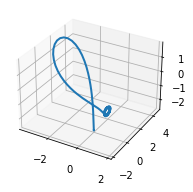

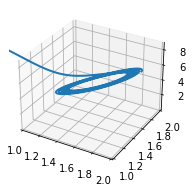

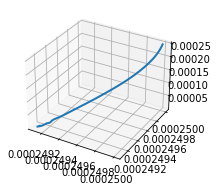

In [7]:
fig1 = plt.figure(figsize=(3,3))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(z_sim[:,0], z_sim[:,1], z_sim[:,2], linewidth=2)

fig2 = plt.figure(figsize=(3,3))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot(z_sim_transformed[:,0], z_sim_transformed[:,1], z_sim_transformed[:,2], linewidth=2)
ax2.set_xlim(1, 2)
ax2.set_ylim(1, 2)

fig3 = plt.figure(figsize=(3,3))
ax3 = fig3.add_subplot(111, projection='3d')
ax3.plot(lorenz_sim[:,0], lorenz_sim[:,1], lorenz_sim[:,2], linewidth=2)

/home/evan/dev/school/amath575/SindyAutoencoders/venv/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.


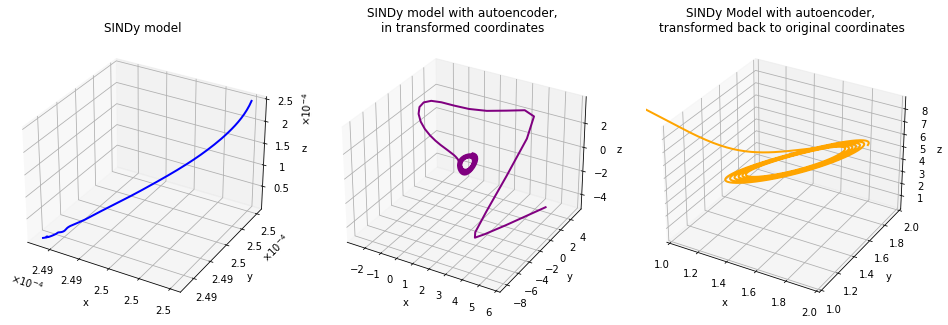

In [36]:
# Make the plots prettier
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import ScalarFormatter

class SigFigFormatter(ScalarFormatter):
    def _set_format(self):
        self.format = "%1.3g"

sigfigformatter = SigFigFormatter(useMathText=True)
sigfigformatter.set_scientific(True)
sigfigformatter.set_powerlimits((0, 0))

fig = plt.figure(figsize=(21, 5))
ax0 = fig.add_subplot(121, projection = '3d')
ax0.plot(lorenz_sim[:,0], lorenz_sim[:,1], lorenz_sim[:,2], linewidth=2, color = 'blue', label = 'simulated')
ax0.set_title(rf"SINDy model")
ax0.set_xlabel("x"); ax0.set_ylabel("y"); ax0.set_zlabel("z")
ax0.xaxis.set_major_formatter(sigfigformatter)
ax0.yaxis.set_major_formatter(sigfigformatter)
ax0.zaxis.set_major_formatter(sigfigformatter)
ax0.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

ax1 = fig.add_subplot(132, projection='3d')
ax1.plot(z_sim[:,0], z_sim[:,1], z_sim[:,2], linewidth=2, color = 'purple', label = 'discovered')
ax1.set_title("SINDy model with autoencoder,\nin transformed coordinates")
ax1.set_xlabel("x"); ax1.set_ylabel("y"); ax1.set_zlabel("z", labelpad=1)

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(z_sim_transformed[:,0], z_sim_transformed[:,1], z_sim_transformed[:,2], linewidth=2, color = 'orange', label = 'transformed')
ax2.set_title("SINDy Model with autoencoder, \ntransformed back to original coordinates")
ax2.set_xlabel("x"); ax2.set_ylabel("y"); ax2.set_zlabel("z", labelpad=1)
ax2.set_xlim([1, 2])
ax2.set_ylim([1, 2])

plt.tight_layout()
plt.show()
fig.savefig('/home/evan/Downloads/lorenz-autoencoder-simulation.pdf')
